In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from validation.metrics import OME, MSE, get_CV_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from MODELS.ViscNN import load_models, create_ViscNN_concat, create_ViscNN_phys,predict_all_cv, ViscNN_concat_HP,  create_ViscNN_phys_HP
from validation.tests import custom_train_test_split, get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, small_shear_test, assign_sample_ids

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-03-30 15:41:35.809656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-30 15:41:36.635332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18086 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


In [3]:
#for each split
    ##Get data from file
    #preprocess and scale
    #make predictions like parity -- but only keep errors
    #save errors
data = ''
GPR_OME = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}
ANN_OME = {'test':{'avg':[], 'std': []}, 'train':{'avg':[], 'std': []}}

models_list = os.listdir('./MODELS')
for test_size in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    #Load Data
    GPR_err = {'test': [], 'train':[]}
    ANN_err = {'test':[], 'train':[]}
    for mod_num in [0,1,2,3,4]:
        test_type = [m for m in models_list if f'LC{mod_num}' in m and f'{test_size}' in m][0]
        print(test_type)
        try:
            train_df = pd.read_pickle(f'MODELS/{test_type}/train_data.pkl')
            test_df = pd.read_pickle(f'MODELS/{test_type}/test_data.pkl')
        except:
            print(f'Did not find {test_type}')
            continue
        #Preprocess, scale
        fp_cols = []
        for c in train_df.columns:
            if isinstance(c, str):
                if 'fp' in c:
                    fp_cols.append(c)

        logMw = np.array(train_df['Mw']).reshape((-1,1))
        shear = np.array(train_df['Shear_Rate']).reshape((-1,1))
        Temp = np.array(train_df['Temperature']).reshape((-1,1))
        Temp = 1/(Temp+273.15)
        PDI = np.array(train_df['PDI']).reshape((-1,1))

        scaler = MinMaxScaler(copy = False)
        XX = np.array(scaler.fit(train_df.filter(fp_cols)).transform(train_df.filter(fp_cols)))
        yy = np.array(train_df.loc[:,'Melt_Viscosity']).reshape((-1,1))

        y_scaler = MinMaxScaler().fit(yy)
        yy = y_scaler.transform(yy);
        T_scaler = MinMaxScaler().fit(Temp)
        T = T_scaler.transform(Temp);
        M_scaler = MinMaxScaler().fit(logMw)
        M = M_scaler.transform(logMw);
        S_trans = PowerTransformer(standardize = False).fit(shear)
        S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
        S = S_scaler.transform(S_trans.transform(shear))
        P_scaler = MinMaxScaler().fit(PDI)
        P = P_scaler.transform(PDI)
        #shear = S_scaler.transform((shear))
        #gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)
        
        y_test = y_scaler.transform(np.array(test_df.loc[:,'Melt_Viscosity']).reshape((-1,1)))
        X_test = np.array(scaler.transform(test_df.filter(fp_cols)))
        M_test = M_scaler.transform(np.array(test_df['Mw']).reshape((-1,1)))
        S_test = S_scaler.transform(S_trans.transform(np.array(test_df['Shear_Rate']).reshape((-1,1))))
        T_test = np.array(test_df['Temperature']).reshape((-1,1))
        T_test = T_scaler.transform(1/(T_test+273.15))
        P_test = P_scaler.transform(np.array(test_df['PDI']).reshape((-1,1)))

        #Load Models
        models, history, gpr_models, gp_cv, NN_cv = load_models(date = test_type[:10], data_type = test_type[11:], NN_models = [create_ViscNN_concat])
        model_reloaded = True

        #Predict
        yy = y_scaler.inverse_transform(yy)
        y_test = y_scaler.inverse_transform(y_test)
        test_pred, test_var,_ = predict_all_cv(models[0],[X_test, M_test, S_test, T_test, P_test])
        train_pred, train_var,_ = predict_all_cv(models[0],[XX, M, S, T, P])
        test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
        train_pred = y_scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
        ANN_err['test'].append(OME(y_test, test_pred))
        ANN_err['train'].append(OME(yy, train_pred))

        gpr_model = gpr_models[5] 
        X_ = np.concatenate((X_test, M_test, S_test, T_test, P_test), axis = 1)
        X_train = np.concatenate((XX, M, S, T, P), axis = 1)
        test_pred, var = gpr_model.predict_f_compiled(tf.convert_to_tensor(X_, dtype=tf.float64))
        train_pred, var_train = gpr_model.predict_f_compiled(X_train)
        test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
        train_pred = y_scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
        GPR_err['train'].append(OME(yy, train_pred))
        GPR_err['test'].append(OME(y_test, test_pred))
    GPR_OME['test']['avg'].append(np.mean(GPR_err['test']))
    GPR_OME['test']['std'].append(np.std(GPR_err['test']))
    GPR_OME['train']['avg'].append(np.mean(GPR_err['train']))
    GPR_OME['train']['std'].append(np.std(GPR_err['train']))
    ANN_OME['test']['avg'].append(np.mean(ANN_err['test']))
    ANN_OME['test']['std'].append(np.std(ANN_err['test']))
    ANN_OME['train']['avg'].append(np.mean(ANN_err['train']))
    ANN_OME['train']['std'].append(np.std(ANN_err['train']))


2022-03-17_LC0_split_test_0.9


2022-03-30 15:41:45.579692: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8344a20


2022-03-24_LC1_split_test_0.9
2022-03-24_LC2_split_test_0.9
2022-03-25_LC3_split_test_0.9
2022-03-25_LC4_split_test_0.9
2022-03-17_LC0_split_test_0.8
2022-03-24_LC1_split_test_0.8
2022-03-24_LC2_split_test_0.8
2022-03-25_LC3_split_test_0.8
2022-03-25_LC4_split_test_0.8
2022-03-17_LC0_split_test_0.7
2022-03-24_LC1_split_test_0.7
2022-03-24_LC2_split_test_0.7
2022-03-25_LC3_split_test_0.7
2022-03-25_LC4_split_test_0.7
2022-03-17_LC0_split_test_0.6
2022-03-24_LC1_split_test_0.6
2022-03-24_LC2_split_test_0.6
2022-03-25_LC3_split_test_0.6
2022-03-25_LC4_split_test_0.6
2022-03-17_LC0_split_test_0.5
2022-03-24_LC1_split_test_0.5
2022-03-25_LC2_split_test_0.5
2022-03-25_LC3_split_test_0.5
2022-03-25_LC4_split_test_0.5
2022-03-17_LC0_split_test_0.4
2022-03-24_LC1_split_test_0.4
2022-03-25_LC2_split_test_0.4
2022-03-25_LC3_split_test_0.4
2022-03-25_LC4_split_test_0.4
2022-03-17_LC0_split_test_0.3
2022-03-24_LC1_split_test_0.3
2022-03-25_LC2_split_test_0.3
2022-03-25_LC3_split_test_0.3
2022-03-25

In [8]:
def LC_viz(errors, title):
    train_size = np.linspace(0.1,0.9,9)
    plt.plot(train_size, errors['train']['avg'], label = 'Train')
    plt.fill_between(train_size, np.array(errors['train']['avg']) - np.array(errors['train']['std']), np.array(errors['train']['avg']) + np.array(errors['train']['std']), alpha = 0.2)
    plt.plot(train_size, errors['test']['avg'], label = 'Validation')
    plt.fill_between(train_size, np.array(errors['test']['avg']) - np.array(errors['test']['std']), np.array(errors['test']['avg']) + np.array(errors['test']['std']), alpha = 0.2)
    plt.title(title)
    plt.xlabel('Train Size Frac')
    plt.ylabel('OME')
    plt.legend()
    plt.show()

In [9]:
ANN_OME

{'test': {'avg': [0.6839961,
   0.5487947,
   0.44744793,
   0.42139658,
   0.38100833,
   0.37221485,
   0.35965955,
   0.3391672,
   0.29993254],
  'std': [0.07081158,
   0.022270499,
   0.027781483,
   0.015872505,
   0.026193393,
   0.006827742,
   0.04656972,
   0.01994452,
   0.04341919]},
 'train': {'avg': [0.47307673,
   0.39996234,
   0.3397178,
   0.34054193,
   0.31452593,
   0.30646342,
   0.3000997,
   0.28165218,
   0.27633008],
  'std': [0.05866872,
   0.036305718,
   0.025039792,
   0.00900412,
   0.010428372,
   0.016562393,
   0.022316461,
   0.012284879,
   0.008423251]}}

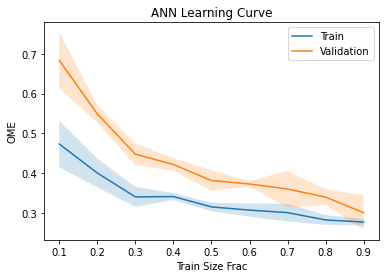

In [10]:
LC_viz(ANN_OME, 'ANN Learning Curve')

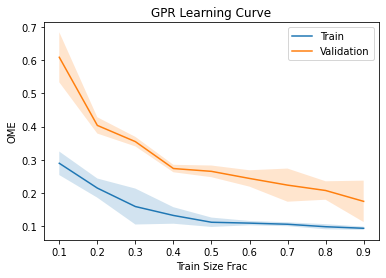

In [11]:
LC_viz(GPR_OME, 'GPR Learning Curve')